# COMP338 Assignment 2 - Convolutional Neural Networks (CNNs)

### PREREQUISITES: Importing The Dataset From GDrive ###

In [26]:
import itertools
import time


import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [27]:
# DATA LOADER #

'''
Assignment 2

author  : Shan Luo
created : 20/11/20 5:30 PM
'''

import os
import sys
from torch.utils.data import Dataset
import numpy as np
import scipy.io as scio
from skimage import io
import pdb



class imageDataset(Dataset): 

    def __init__(self, root_dir, file_path, imSize = 250, shuffle=False):
        self.imPath = np.load(file_path) 
        self.root_dir = root_dir
        self.imSize = imSize
        self.file_path=file_path


    def __len__(self):
        return len(self.imPath)

    def __getitem__(self, idx):
    	# print(self.root_dir)
    	# print(self.imPath[idx])
        im = io.imread(os.path.join(self.root_dir, self.imPath[idx]))  # read the image

        if len(im.shape) < 3: # if there is grey scale image, expand to r,g,b 3 channels
            im = np.expand_dims(im, axis=-1)
            im = np.repeat(im,3,axis = 2)

        img_folder = self.imPath[idx].split('/')[-2]
        if img_folder =='faces':
            label = np.zeros((1, 1), dtype=int)
        elif img_folder == 'dog':
            label = np.zeros((1, 1), dtype=int)+1
        elif img_folder == 'airplanes':
            label = np.zeros((1, 1), dtype=int)+2
        elif img_folder == 'keyboard':
            label = np.zeros((1, 1), dtype=int)+3
        elif img_folder == 'cars':
            label = np.zeros((1, 1), dtype=int)+4


        img = np.zeros([3,im.shape[0],im.shape[1]]) # reshape the image from HxWx3 to 3xHxW
        img[0,:,:] = im[:,:,0]
        img[1,:,:] = im[:,:,1]
        img[2,:,:] = im[:,:,2]

        imNorm = np.zeros([3,im.shape[0],im.shape[1]]) # normalize the image
        imNorm[0, :, :] = (img[0,:,:] - np.max(img[0,:,:]))/(np.max(img[0,:,:])-np.min(img[0,:,:])) -0.5
        imNorm[1, :, :] = (img[1,:,:] - np.max(img[1,:,:]))/(np.max(img[1,:,:])-np.min(img[1,:,:])) -0.5
        imNorm[2, :, :] = (img[2,:,:] - np.max(img[2,:,:]))/(np.max(img[2,:,:])-np.min(img[2,:,:])) -0.5

        return{
            'imNorm': imNorm.astype(np.float32),
            'label':np.transpose(label.astype(np.float32))                  #image label
            }

class DefaultTrainSet(imageDataset):
    def __init__(self, **kwargs):
        script_folder = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__)))) 
         #  img_list_train.npy that contains the path of the training images is provided 
        default_path = os.path.join(script_folder, 'img_list_train.npy')
        root_dir = os.path.join(script_folder, 'data')
        super(DefaultTrainSet, self).__init__(root_dir, file_path=default_path, imSize = 250,**kwargs)


class DefaultTestSet(imageDataset):

    def __init__(self, **kwargs):
        script_folder = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
        #  img_list_test.npy that contains the path of the testing images is provided
        default_path = os.path.join(script_folder, 'img_list_test.npy')  
        root_dir = os.path.join(script_folder, 'data')
        super(DefaultTestSet, self).__init__(root_dir, file_path=default_path, imSize = 250,**kwargs)
  

In [28]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

# Creating datasets fro the training and test images
# using FashionMNIST

training_data = datasets.FashionMNIST(
    root="drive/My Drive/COMP338_Assignment2_Dataset/training",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="drive/My Drive/COMP338_Assignment2_Dataset/test",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

Feature batch shape: torch.Size([16, 1, 28, 28])
Labels batch shape: torch.Size([16])


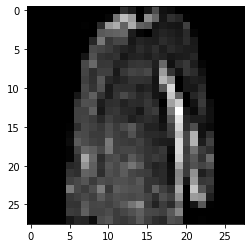

Label: 6


In [29]:
# A test to see whether the images were imported successfully
import matplotlib.pyplot as plt

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Step 1 (40 marks) Feature extraction using a Convolution Neural Network ##

### 1. Install PyTorch and Torchvision ###

In [30]:
!pip install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip install torchvision

ERROR: torch-0.4.1-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.


In [31]:
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.optim as optim

In [76]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.cnn_layers = Sequential(
            # First Hidden Layer
            Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            BatchNorm2d(64),
            ReLU(inplace=True),

            # Second Hidden Layer (Pooling Layer 1)
            MaxPool2d(kernel_size=3, stride=2, padding=0),

            # Third Hidden Layer
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            ReLU(inplace=True),

            # Fourth Hidden Layer (Pooling Layer 2)
            MaxPool2d(kernel_size=3, stride=2, padding=0),
        )

        self.linear_layers = Sequential(
            # Fully Connected Layer
            Linear(3 * 250 * 250, 64 * 5)
        )

        

        '''
        # First Hidden Layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)

        # Second Hidden Layer (Pooling Layer 1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)

        # Third Hidden Layer
        self.conv2 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)

        # Fourth Hidden Layer (Pooling Layer 2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        
        # cf comments in forward() to have step by step comments
        # on the shape (how we pass from a 3x32x32 input image to a 18x16x16 volume)
        self.fc = nn.Linear(18 * 16 * 16, 64)

        '''
        #self.fc2 = nn.Linear(64, 10)

     # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [77]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # cf comments in forward() to have step by step comments
        # on the shape (how we pass from a 3x32x32 input image to a 18x16x16 volume)
        self.fc1 = nn.Linear(18 * 16 * 16, 64) 
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 18x32x32 (Recall: (N -F+2P)/S+1) = (32-3+2*1)/1+1=32
        x = F.relu(self.conv1(x))
        # 18x32x32 -> 18x16x16 (Recall: (N -F+2P)/S+1) = (32-2+2*0)/2+1 = 16
        x = self.pool(x)
        # 18x16x16 -> 4608
        x = x.view(-1, 18 * 16 * 16)
        # 4608 -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 10
        # The softmax non-linearity is applied later (cf createLossAndOptimizer() fn)
        x = self.fc2(x)
        return x

In [56]:
def softmaxProbabiities(e):
  sm = nn.Softmax2d()
  e = sm(e)
  print(e)

## Step 2 - (10 marks) Define a loss function and the optimizer ##

In [57]:
def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

## Step 3 - (20 marks) Train The Network ##

In [58]:
from torch.utils.data.sampler import SubsetRandomSampler

n_training_samples = 20000 # Max: 50 000 - n_val_samples
n_val_samples = 5000
n_test_samples = 5000

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
# (In the last case, indexes do not need to account for training ones because the train=False parameter in datasets.CIFAR will select from the test set)

In [59]:
import torch

# Data Loader #

def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(training_data, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=2)

# Use larger batch size for validation to speed up computation
val_loader = torch.utils.data.DataLoader(training_data, batch_size=64, sampler=val_sampler,
                                          num_workers=2)

In [60]:
import torch as th

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

if th.cuda.is_available():
  # Make CuDNN Determinist
  th.backends.cudnn.deterministic = True
  th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [72]:
def train(net, batch_size, n_epochs, learning_rate):
    """
    Train a neural network and print statistics of the training
    
    :param net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []
    
    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"
    
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, (inputs, labels) in enumerate(train_loader):

            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            print(inputs)
            outputs = net(inputs)
            print("Hello")
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

           

            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()


            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()
        with th.no_grad():
          for inputs, labels in val_loader:
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)
              # Forward pass
              predictions = net(inputs)
              val_loss = criterion(predictions, labels)
              total_val_loss += val_loss.item()
            
        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            th.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(th.load(best_model_path))
    
    return train_history, val_history

In [87]:
net = CNN()

x = torch.randn(2, 3, 37, 37)


#train_history, val_history = train(net, batch_size=16, n_epochs=20, learning_rate=0.01)

In [90]:
# SECOND VERSION

# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []

def train(epoch):
    net.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(training_data), Variable(training_data.train_labels)
    # getting the validation set
    x_val, y_val = Variable(test_data), Variable(test_data.test_labels)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    criterion, optimizer = createLossAndOptimizer(net, 0.001)

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = net(x_train)
    output_val = net(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

for epoch in range(n_epochs):
    train(epoch)

TypeError: ignored